This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/main/wallaroo-testing-tutorials/wallaro-assay-builder-tutorial).

#  Model Insights

The Model Insights feature lets you monitor how the environment that your model operates within may be changing in ways that affect it's predictions so that you can intervene (retrain) in an efficient and timely manner. Changes in the inputs, **data drift**, can occur due to errors in the data processing pipeline or due to changes in the environment such as user preference or behavior. 

This notebook focuses on interactive exploration over historical data. After you are comfortable with how your data has behaved historically, you can schedule this same analysis (called an *assay*) to automatically run periodically, looking for indications of data drift or concept drift.

In this notebook, we will be running a drift assay on the BYOP model. We want to see if the distribution of predicted spam classifications changes over time.

## Goal

Model insights monitors the output of the spam classifier model over a designated time window and compares it to an expected baseline distribution. We measure the difference between  the window distribution and the baseline distribution; large differences indicate that the behavior of the model (or its inputs) has changed from what we expect. This possibly indicates a change that should be accounted for, possibly by retraining the models.

### Resources

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * `models/xgb_model.onnx` and `models/gbr_model.onnx`: Rival models that will be tested against the champion.
* Data:
  * `data/xtest-1.df.json` and `data/xtest-1k.df.json`:  DataFrame JSON inference inputs with 1 input and 1,000 inputs.
  * `data/xtest-1k.arrow`:  Apache Arrow inference inputs with 1 input and 1,000 inputs.

### Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame


## Steps

* Deploying a sample ML model used to determine house prices based on a set of input parameters.
* Creating an Assay from a set of baseline start and end dates, and an Assay from baseline data from a numpy array.
* Perform an interactive assay run and display statistics about that assay.
* Display results for each assay window in the interactive assay.
* Upload the assay.

### Import Libraries

The first step will be to import our libraries, and set variables used through this tutorial.

In [42]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import datetime
import time



# used for unique connection names

import string
import random

suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))
suffix=''

# used to make a unique workspace
suffix=''

workspace_name = f'assay-demonstration-tutorial{suffix}'
main_pipeline_name = f'assay-demonstration-tutorial'
model_name_control = f'house-price-estimator'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
assay_name=f"house price test{suffix}"

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

In [11]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name, workspace):
    pipelines = workspace.pipelines()
    pipe_filter = filter(lambda x: x.name() == name, pipelines)
    pipes = list(pipe_filter)
    # we can't have a pipe in the workspace with the same name, so it's always the first
    if pipes:
        pipeline = pipes[0]
    else:
        pipeline = wl.build_pipeline(name)
    return pipeline

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [12]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [13]:
workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

{'name': 'assay-demonstration-tutorial', 'id': 28, 'archived': False, 'created_by': 'df2b4a6c-b749-466a-95b4-60cf14fc354d', 'created_at': '2024-02-01T19:46:21.402729+00:00', 'models': [{'name': 'housepricesagacontrol', 'versions': 3, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 2, 2, 15, 45, 45, 978338, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 2, 1, 19, 46, 23, 228360, tzinfo=tzutc())}], 'pipelines': [{'name': 'assay-demonstration-tutorial', 'create_time': datetime.datetime(2024, 2, 1, 19, 46, 24, 140658, tzinfo=tzutc()), 'definition': '[]'}]}

### Upload The Champion Model

For our example, we will upload the champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `housingcontrol`.

In [14]:
housing_model_control = (wl.upload_model(model_name_control, 
                                        model_file_name_control, 
                                        framework=Framework.ONNX)
                                        .configure(tensor_fields=["tensor"])
                        )

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `housepricepipeline`, set `housingcontrol` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step.

In [15]:
mainpipeline = get_pipeline(main_pipeline_name, workspace)
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()

mainpipeline.deploy(deployment_config = deploy_config)

name,assay-demonstration-tutorial
created,2024-02-01 19:46:24.140658+00:00
last_updated,2024-02-07 20:33:32.287940+00:00
deployed,True
arch,None
tags,
versions,"f02cf5cd-eece-4ebf-b563-d9d7fad963f6, eedae8d6-ab61-42ab-b9e8-5bf5e4511158, fece4440-2841-45f1-bb5f-95fcdc959327, 9c5a5b72-4976-406b-a4a3-f02e730bb9db, b917929a-01d0-4690-9c08-5edd2094761d"
steps,housepricesagacontrol
published,False


### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around `$700k`, the other with a house determined to be around `$1.5` million.  We'll also save the start and end periods for these events to for later log functionality.

In [16]:
normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,check_failures
0,2024-02-07 20:33:49.207,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [17]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,check_failures
0,2024-02-07 20:33:49.513,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


### Generate Sample Data

Before creating the assays, we must generate data for the assays to build from.

For this example, we will:

* Perform sample inferences based on lower priced houses and use that as our baseline.
* Generate inferences spread across all house values, plus specific set of high priced houses create inference outputs that will be outside the baseline.  This is used in later steps to demonstrate baseline previews and assay configuration.

#### Inference Results History Generation

To start the demonstration, we'll create a baseline of values from houses with small estimated prices and set that as our baseline.

We will save the beginning and end periods of our baseline data to the variables `assay_baseline_start` and `assay_baseline_end`.

In [18]:
small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# Where the baseline data will start
assay_baseline_start = datetime.datetime.now()

# These inputs will be random samples of small priced houses.  Around 30,000 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)

# Wait 30 seconds to set this data apart from the rest
time.sleep(30)
small_results = mainpipeline.infer(small_houses)

# Set the baseline end

assay_baseline_end = datetime.datetime.now()

#### Generate Numpy Baseline Values

This process generates a numpy array of the inference results used as baseline data in later steps.

In [19]:
# get the numpy values

# set the results to a non-array value
small_results_baseline_df = small_results.copy()
small_results_baseline_df['variable']=small_results['out.variable'].map(lambda x: x[0])
small_results_baseline_df

# set the numpy array
small_results_baseline = small_results_baseline_df['variable'].to_numpy()

#### Assay Test Data

The following will generate inference data for us to test against the assay baseline.  For this, we will add in house data that generate higher house prices than the baseline data we used earlier.

This process should take 4 minutes to generate the historical data we'll later use in our assays.

In [20]:
# Get a spread of house values

# # Set the start for our assay window period.
assay_window_start = datetime.datetime.now()

time.sleep(65)
inference_size = 1000

# And a spread of large house values

small_houses_inputs = pd.read_json('./data/smallinputs.df.json', orient="records")
small_houses = small_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

mainpipeline.infer(small_houses)

time.sleep(65)

In [21]:
# Get a spread of large house values

time.sleep(65)
inference_size = 1000

# And a spread of large house values

big_houses_inputs = pd.read_json('./data/biginputs.df.json', orient="records")
big_houses = big_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

mainpipeline.infer(big_houses)

time.sleep(65)

## Model Insights via the Wallaroo Dashboard SDK

Assays generated through the Wallaroo SDK can be previewed, configured, and uploaded to the Wallaroo Ops instance.  The following is a condensed version of this process.  For full details see the [Wallaroo SDK Essentials Guide: Assays Management]({{<ref "wallaroo-sdk-essentials-assays">}}) guide.

Model drift detection with assays using the Wallaroo SDK follows this general process.

* Define the Baseline: From either historical inference data for a specific model in a pipeline, or from a pre-determine array of data, a **baseline** is formed.
* Assay Preview:  Once the baseline is formed, we **preview the assay** and configure the different options until we have the the best method of detecting environment or model drift.
* Create Assay:  With the previews and configuration complete, we **upload** the assay.  The assay will perform an analysis on a regular scheduled based on the configuration.
* Get Assay Results:  Retrieve the analyses and use them to detect model drift and possible sources.
* Pause/Resume Assay:  Pause or restart an assay as needed.

### Define the Baseline

Assay baselines are defined with the [`wallaroo.client.build_assay`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/client/#Client.build_assay) method. Through this process we define the baseline from either a range of dates or pre-generated values.

`wallaroo.client.build_assay` take the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_name** | *String* (*Required*) - required | The name of the assay.  Assay names **must** be unique across the Wallaroo instance. |
| **pipeline** | *wallaroo.pipeline.Pipeline* (*Required*) | The pipeline the assay is monitoring. |
| **model_name** | *String* (*Required*)  | The name of the model to monitor.
| **iopath** | *String* (*Required*) | The input/output data for the model being tracked in the format `input/output field index`.  Only one value is tracked for any assay.  For example, to track the **output** of the model's field `house_value` at index `0`, the `iopath` is `'output house_value 0`. |
| **baseline_start** | *datetime.datetime* (*Optional*) | The start time for the inferences to use as the baseline.  **Must be included with `baseline_end`.  Cannot be included with `baseline_data`.** |
| **baseline_end** | *datetime.datetime* (*Optional*) | The end time of the baseline window. the baseline. Windows start immediately after the baseline window and are run at regular intervals continuously until the assay is deactivated or deleted.  **Must be included with `baseline_start`.  Cannot be included with `baseline_data`.**. |
| **baseline_data** | *numpy.array* (*Optional*) | The baseline data in numpy array format.  **Cannot be included with either `baseline_start` or `baseline_data`. |

Baselines are created in one of two ways:

* **Date Range**:  The `baseline_start` and `baseline_end` retrieves the inference requests and results for the pipeline from the start and end period.  This data is summarized and used to create the baseline.
* **Numpy Values**:  The `baseline_data` sets the baseline from a provided numpy array.

#### Define the Baseline Example

This example shows two methods of defining the baseline for an assay:

* `"assays from date baseline"`: This assay uses historical inference requests to define the baseline.  This assay is saved to the variable `assay_builder_from_dates`.
* `"assays from numpy"`:  This assay uses a pre-generated numpy array to define the baseline.  This assay is saved to the variable `assay_builder_from_numpy`.

In both cases, the following parameters are used:

| Parameter | Value |
|---|---|---|
| **assay_name** | `"assays from date baseline"` and `"assays from numpy"` |
| **pipeline** | `mainpipeline`:  A pipeline with a ML model that predicts house prices.  The output field for this model is `variable`. |
| **model_name** | `"houseprice-predictor"` - the model name set during model upload. |
| **iopath** | These assays monitor the model's **output** field **variable** at index 0.  From this, the `iopath` setting is `"output variable 0"`.  |

The difference between the two assays' parameters determines how the baseline is generated.

* `"assays from date baseline"`: Uses the `baseline_start` and `baseline_end` to set the time period of inference requests and results to gather data from.
* `"assays from numpy"`:  Uses a pre-generated numpy array as for the baseline data.

For each of our assays, we will set the time period of inferences as part of our baseline creation.

In [24]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
baseline_from_dates_run = assay_builder_from_dates.build().interactive_run()[0]



# assay builder by baseline
assay_builder_from_numpy = wl.build_assay(assay_name="assays from numpy", 
                               pipeline=mainpipeline, 
                               model_name="house-price-estimator", 
                               iopath="output variable 0", 
                               baseline_data = small_results_baseline)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_numpy.add_run_until(datetime.datetime.now())
assay_builder_from_numpy.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

baseline_from_numpy_run = assay_builder_from_numpy.build().interactive_run()[0]

With the baseline's of each assay generated, examine the data and generate some visual representations.

#### Baseline Histogram Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_histogram`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a histogram chart of the assay baseline generated from the provided parameters.

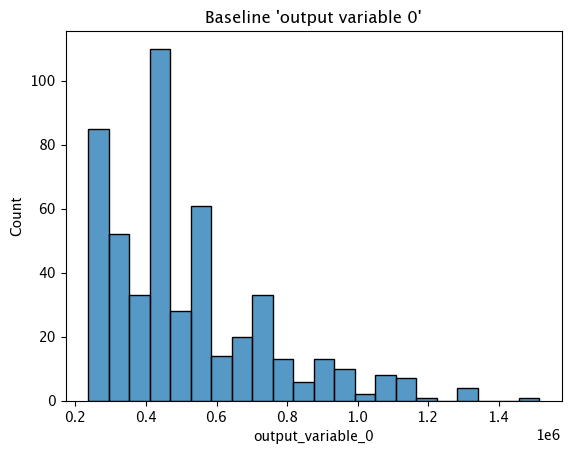

In [25]:
assay_builder_from_dates.baseline_histogram()

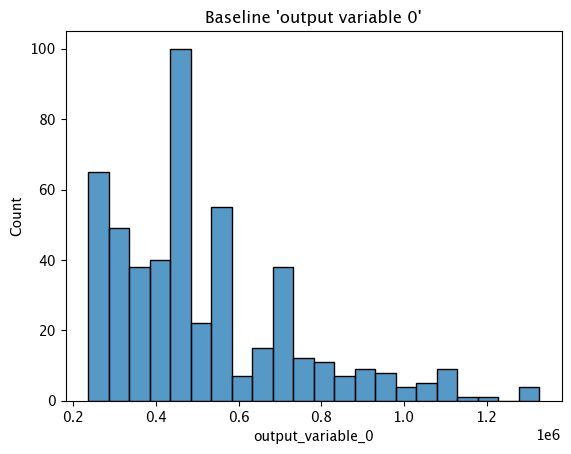

In [26]:
assay_builder_from_numpy.baseline_histogram()

#### Baseline KDE Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_kde`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a Kernel Density Estimation (KDE) chart of the assay baseline generated from the provided parameters.

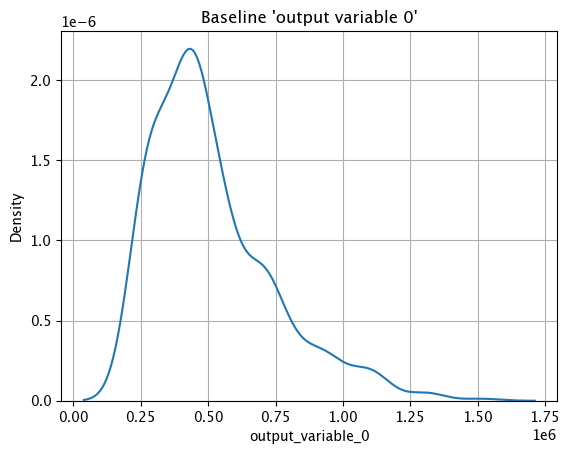

In [27]:
assay_builder_from_dates.baseline_kde()

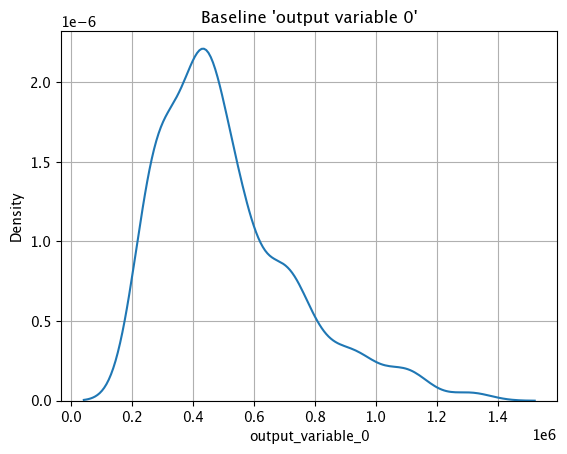

In [28]:
assay_builder_from_numpy.baseline_kde()

#### Baseline ECDF Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_ecdf`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a Empirical Cumulative Distribution Function (CDF) chart of the assay baseline generated from the provided parameters.

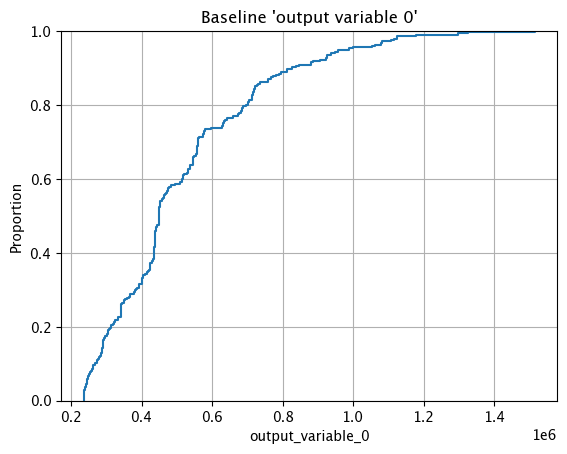

In [29]:
assay_builder_from_dates.baseline_ecdf()

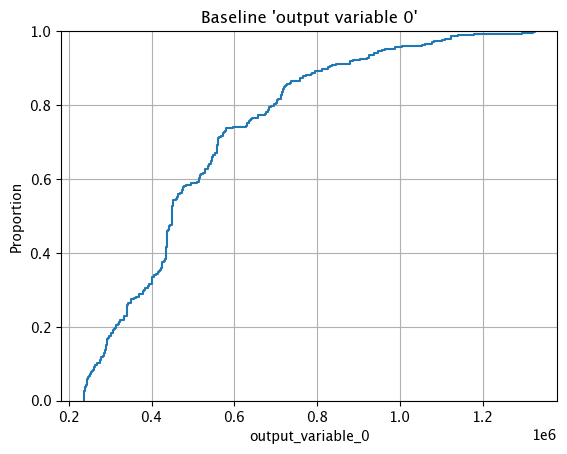

In [30]:
assay_builder_from_numpy.baseline_ecdf()

#### Baseline DataFrame

The method [`wallaroo.assay_config.AssayBuilder.baseline_ecdf`](/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a dataframe of the assay baseline generated from the provided parameters.  This includes:

* `metadata`:  The inference metadata with the model information, inference time, and other related factors.
* `in` data:  Each input field assigned with the label `in.{input field name}`.
* `out` data:  Each output field assigned with the label `out.{output field name}`

Note that for assays generated from numpy values, there is only the `out` data based on the supplied baseline data.

In the following example, the baseline DataFrame is retrieved.  For space purposes, only the `time` and output variable is displayed for the baseline generated by dates.

In [33]:
assay_builder_from_dates.baseline_dataframe().loc[:, ['time', 'output_variable_0']]

,time,output_variable_0
0,1707338029513,1.514079e+06
1,1707338060042,7.367513e+05
2,1707338060042,1.077279e+06
3,1707338060042,3.685043e+05
4,1707338060042,2.443519e+05
...,...,...
496,1707338060042,4.486278e+05
497,1707338060042,4.371780e+05
498,1707338060042,2.521929e+05
499,1707338060042,2.840815e+05


In [34]:
assay_builder_from_numpy.baseline_dataframe().loc[:, ['output_variable_0']]

,output_variable_0
0,736751.30
1,1077279.10
2,368504.30
3,244351.92
4,516278.63
...,...
495,448627.80
496,437177.97
497,252192.90
498,284081.53


#### Baseline Stats

The method `wallaroo.assay.AssayAnalysis.baseline_stats()` returns a `pandas.core.frame.DataFrame` of the baseline stats.

The baseline stats for each assay are displayed in the examples below.

In [35]:
baseline_from_dates_run.baseline_stats()

,Baseline
count,501
min,236238.671875
max,1514079.375
mean,513975.778318
median,448627.8125
std,227020.413509
start,None
end,None


In [36]:
baseline_from_numpy_run.baseline_stats()

,Baseline
count,500
min,236238.67
max,1325960.8
mean,511975.57226
median,448627.8
std,222793.468828
start,None
end,None


### Assay Preview

Now that the assay is formed, we look at different configuration options and view how the assay baseline and results changes.  Once we determine what gives us the best method of determining model drift, we can create the assay.

For each example two analyses are displayed.  Both are generated from sample data with a width and interval of one minute.

* `assay_builder_from_dates.build().interactive_run()[0]`: This analysis is similar to the baseline and generates a low score.
* `assay_builder_from_dates.build().interactive_run()[1]`: This analysis is generated from values that are very different than the baseline, which generates a high score.

#### Analysis List Chart Scores

Analysis List scores show the assay scores for each assay result interval in one chart.  Values that are outside of the alert threshold are colored red, while scores within the alert threshold are green.

Assay chart scores are displayed with the method [`wallaroo.assay.AssayAnalysisList.chart_scores(title: Optional[str] = None)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay/#AssayAnalysisList.chart_scores), with ability to display an optional title with the chart.

The following example shows retrieving the assay results and displaying the chart scores.  From our example, we have two windows - the first should be green, and the second is red showing that values were outside the alert threshold.

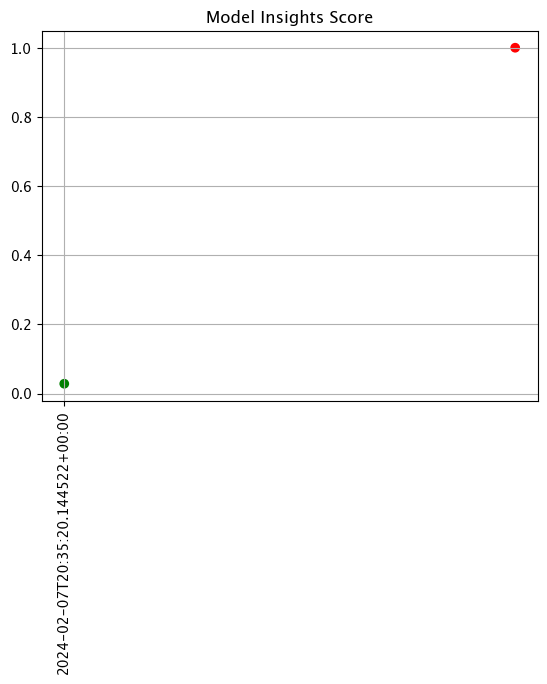

In [55]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set metric PSI mode
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.SUMDIFF)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run().chart_scores()

#### Analysis List DataFrame

`wallaroo.assay.AssayAnalysisList.to_dataframe()` returns a DataFrame showing the assay results for each window aka individual analysis.  This DataFrame contains the following fields:

| Field | Type | Description |
|---|---|---|
| assay_id | **Integer/None** | The assay id.  If this is from an interactive run and not an uploaded assay, the id is `None`.
| name | **String/None** | The name of the assay.  If this is from an interactive run and not an uploaded assay, the name is `None`.
| iopath | **String/None** | The iopath of the assay.  If this is from an interactive run and not an uploaded assay, the iopath is `None`.
| score | **Float** | The assay score. |
| start | **DateTime** | The DateTime start of the assay window.
| min | **Float** | The minimum value in the assay window.
| max  | **Float** | The maximum value in the assay window.
| mean | **Float** | The mean value in the assay window.
| median | **Float** | The median value in the assay window.
| std | **Float** | The standard deviation value in the assay window.
| warning_threshold | **Float/None** | The warning threshold of the assay window.
| alert_threshold | **Float/None** | The alert threshold of the assay window.
| status | **String** | The assay window status.  Values are:  <ul><li>`OK`: The score is within accepted thresholds.</li><li>`Warning`: The score has triggered the `warning_threshold` if exists, but not the `alert_threshold`.</li><li>`Alert`: The score has triggered the the `alert_threshold`.</li></ul> |

For this example, the assay analysis list DataFrame is listed from an interactive run.  For space reasons, only the `score`, `start`, `alert_threshold` and `status` are shown.

From this tutorial, we should have 2 windows of dta to look at, each one minute apart.  The first window should show `status: OK`, with the second window with the very large house prices will show `status: alert`

In [56]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set metric PSI mode
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.SUMDIFF)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
baseline_from_dates_run = assay_builder_from_dates.build().interactive_run()[1]

assay_builder_from_dates.build().interactive_run().to_dataframe().loc[:, ['score', 'start', 'alert_threshold', 'status']]

,score,start,alert_threshold,status
0,0.028399,2024-02-07T20:35:20.144522+00:00,0.25,Ok
1,1.000000,2024-02-07T20:37:20.144522+00:00,0.25,Alert


#### Assay Analysis Chart

The method `wallaroo.assay.AssayAnalysis.chart()` displays a comparison between the baseline and an analysis window.  The following fields are included.

| Field | Type | Description |
|---|---|---|
| **baseline mean** | **Float** | The mean of the baseline values. |
| **window mean** | **Float** | The mean of the window values. |
| **baseline median** | **Float** | The median of the baseline values. |
| **window median** | **Float** | The median of the window values. |
| **bin_mode** | **String** | The binning mode used for the assay. |
| **aggregation** | **String** | The aggregation mode used for the assay. |
| **metric** | **String** | The metric mode used for the assay. |
| **weighted** | **Bool** | Whether the bins were manually weighted. |
| **score** | **Float** | The score from the assay window. |
| **scores** | **List(Float)** | The score from each assay window bin. |
| **index** | **Integer/None** | The window index.  Interactive assay runs are `None`. |

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.00520772807841052
scores = [0.0, 0.0008040331034294781, 0.00010009324303378128, 0.0005128718504664744, 0.0037778397193669257, 1.2890162113860805e-05, 0.0]
index = None


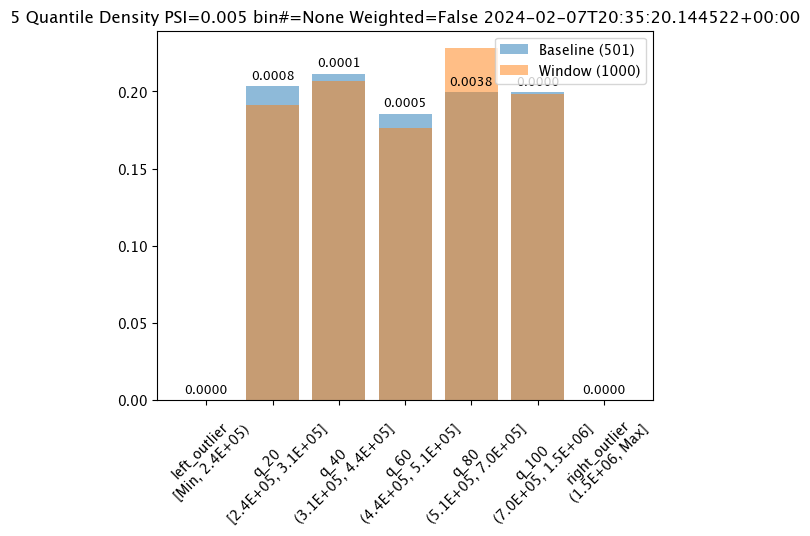

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.8693965086548
scores = [0.0, 0.7361208231835864, 0.7736613502280227, 0.6528484073872128, 0.7174700740703411, 0.7174700740703411, 5.2718257797152965]
index = None


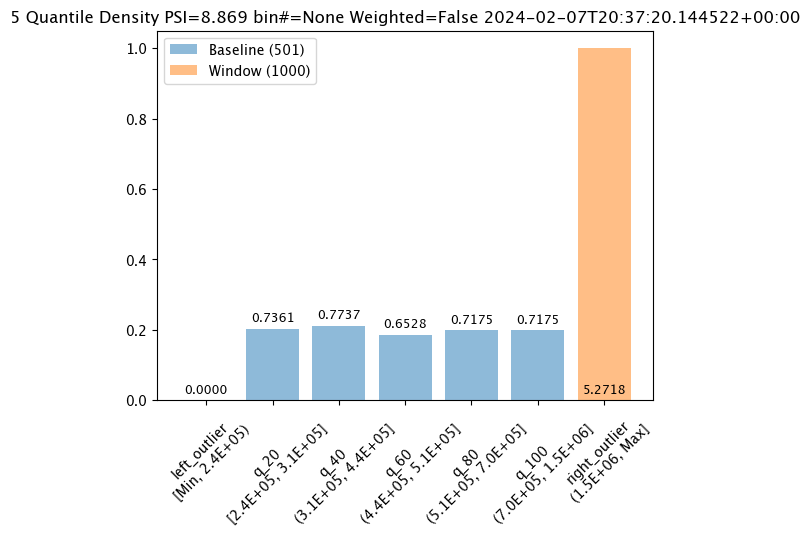

In [69]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run()[0].chart()
assay_builder_from_dates.build().interactive_run()[1].chart()

#### Score Metric

The `score` is a distance between the baseline and the analysis window.  The larger the score, the greater the difference between the baseline and the analysis window.  The following methods are provided determining the score:

* `PSI` (*Default*) - Population Stability Index (PSI).
* `MAXDIFF`: Maximum difference between corresponding bins.
* `SUMDIFF`: Mum of differences between corresponding bins.

The metric type used is updated with the [`wallaroo.assay_config.AssayBuilder.add_metric(metric: wallaroo.assay_config.Metric)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_metric) method.

The following three charts use each of the metrics.  Note how the scores change based on the score type used.

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.00520772807841052
scores = [0.0, 0.0008040331034294781, 0.00010009324303378128, 0.0005128718504664744, 0.0037778397193669257, 1.2890162113860805e-05, 0.0]
index = None


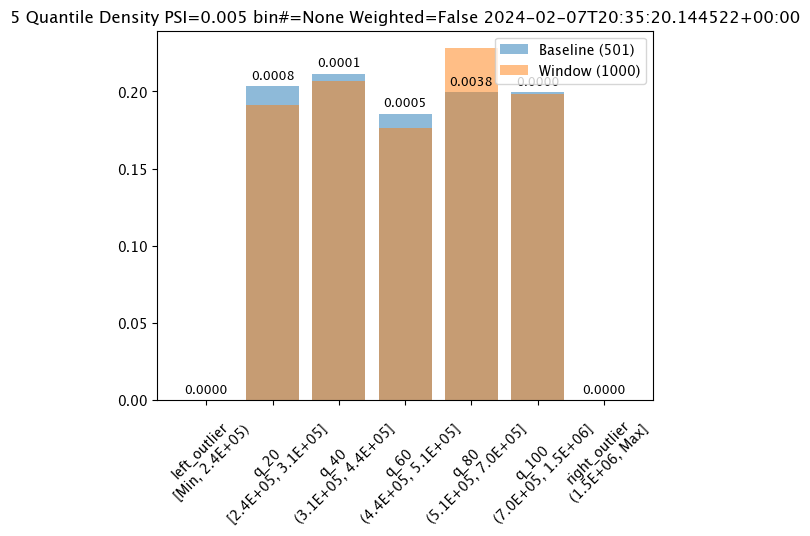

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.8693965086548
scores = [0.0, 0.7361208231835864, 0.7736613502280227, 0.6528484073872128, 0.7174700740703411, 0.7174700740703411, 5.2718257797152965]
index = None


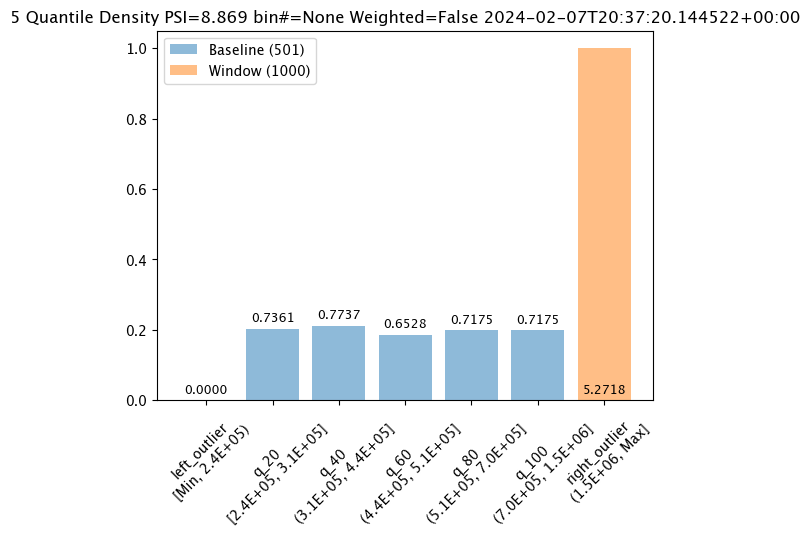

In [70]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set metric PSI mode
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.PSI)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run()[0].chart()
assay_builder_from_dates.build().interactive_run()[1].chart()

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = MaxDiff
weighted = False
score = 0.028399201596806395
scores = [0.0, 0.012592814371257475, 0.004576846307385252, 0.009628742514970062, 0.028399201596806395, 0.001600798403193604, 0.0]
index = 4


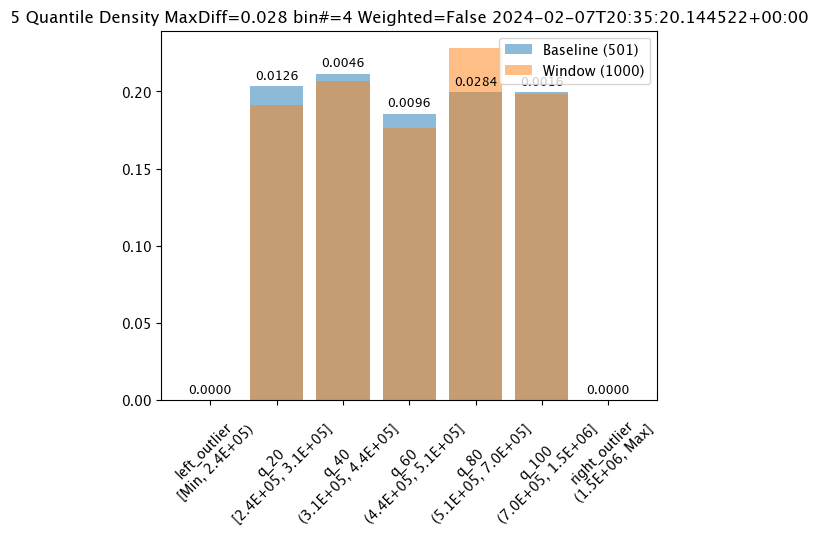

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = MaxDiff
weighted = False
score = 1.0
scores = [0.0, 0.20359281437125748, 0.21157684630738524, 0.18562874251497005, 0.1996007984031936, 0.1996007984031936, 1.0]
index = 6


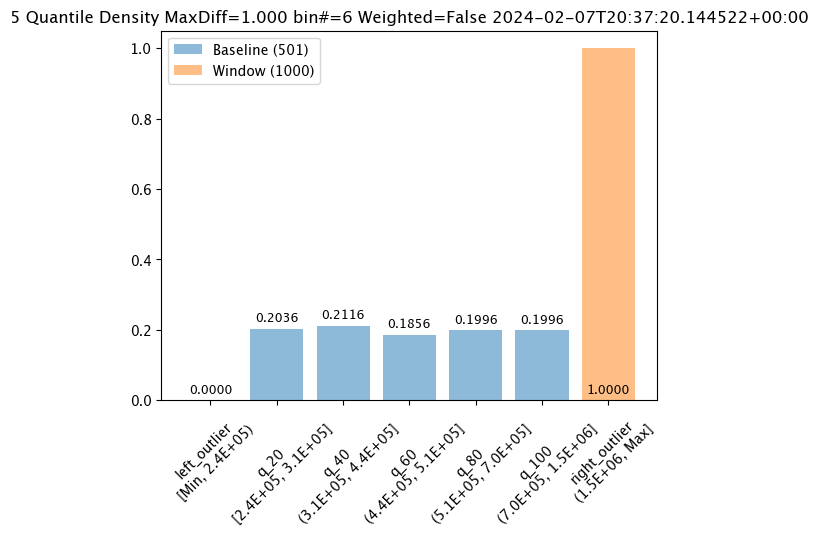

In [68]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set metric PSI mode
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.MAXDIFF)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run()[0].chart()
assay_builder_from_dates.build().interactive_run()[1].chart()

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = SumDiff
weighted = False
score = 0.028399201596806395
scores = [0.0, 0.012592814371257475, 0.004576846307385252, 0.009628742514970062, 0.028399201596806395, 0.001600798403193604, 0.0]
index = None


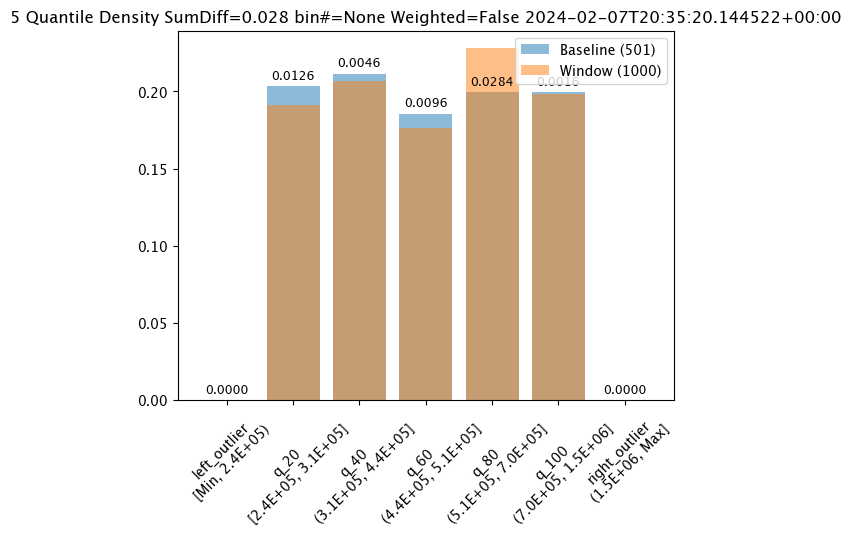

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = SumDiff
weighted = False
score = 1.0
scores = [0.0, 0.20359281437125748, 0.21157684630738524, 0.18562874251497005, 0.1996007984031936, 0.1996007984031936, 1.0]
index = None


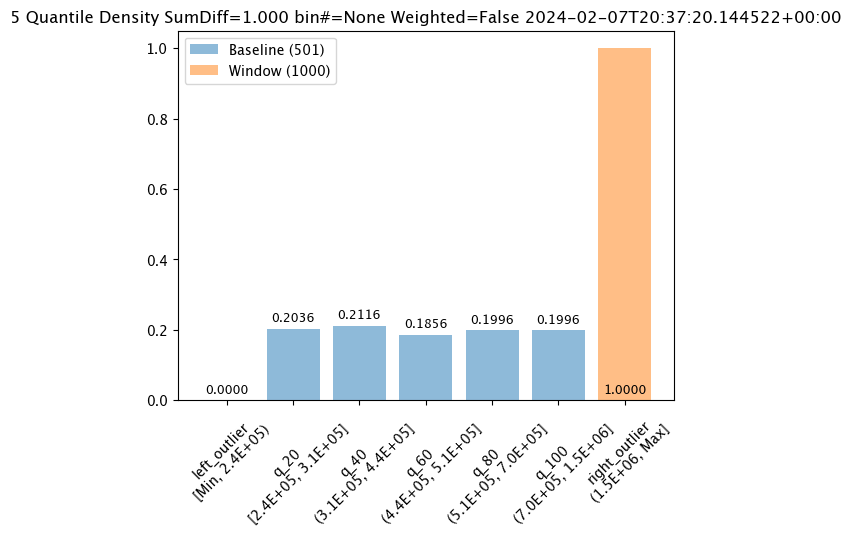

In [71]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set metric PSI mode
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.SUMDIFF)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run()[0].chart()
assay_builder_from_dates.build().interactive_run()[1].chart()

#### Alert Threshold

Assay alert thresholds are modified with the [`wallaroo.assay_config.AssayBuilder.add_alert_threshold(alert_threshold: float)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/) method.  By default alert thresholds are `0.1`.

The following example updates the alert threshold to `0.5`.

In [78]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.add_alert_threshold(0.5)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# get the dataframe from the interactive run
assay_builder_from_dates.build().interactive_run().to_dataframe().loc[:, ['score', 'start', 'alert_threshold', 'status']]

,score,start,alert_threshold,status
0,0.005208,2024-02-07T20:35:20.144522+00:00,0.5,Ok
1,8.869397,2024-02-07T20:37:20.144522+00:00,0.5,Alert


#### Number of Bins

Number of bins sets how the baseline data is partitioned.  The total number of bins includes the set number plus the left_outlier and the right_outlier, so the total number of bins will be the total set + 2.

The number of bins is set with the [`wallaroo.assay_config.UnivariateContinousSummarizerBuilder.add_num_bins(num_bins: int)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_num_bins) method.

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.01936763341991274
scores = [0.0, 3.1984355629053614e-05, 0.0012104424748554526, 0.003504042612477055, 0.0054620786516716745, 4.575782500540267e-05, 0.0019006190378958556, 0.0070072870357337485, 7.291031454356322e-06, 4.7192338774114e-05, 0.00015093805641602358, 0.0]
index = None


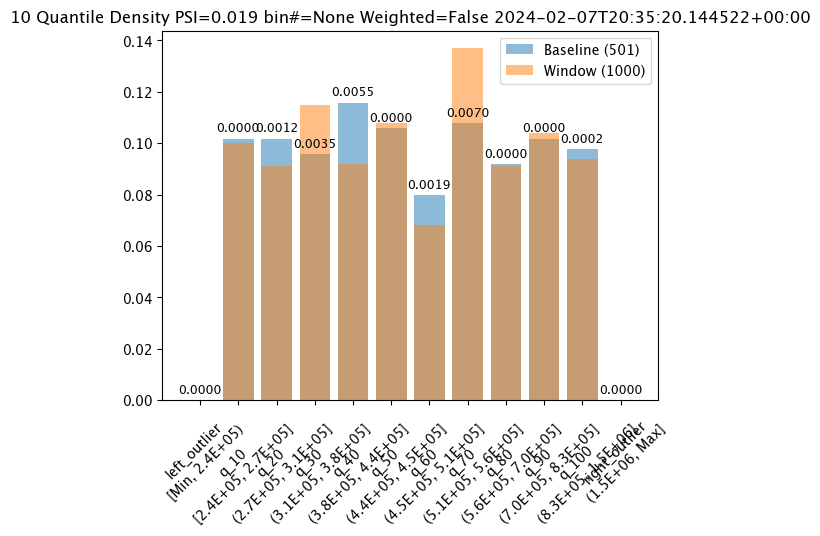

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.122326388340474
scores = [0.0, 0.2916995446658736, 0.2916995446658736, 0.2681491896477076, 0.3480515998945155, 0.3076065878730085, 0.20735189427254225, 0.31561967084401865, 0.2526662455720835, 0.2916995446658736, 0.27595678652368016, 5.2718257797152965]
index = None


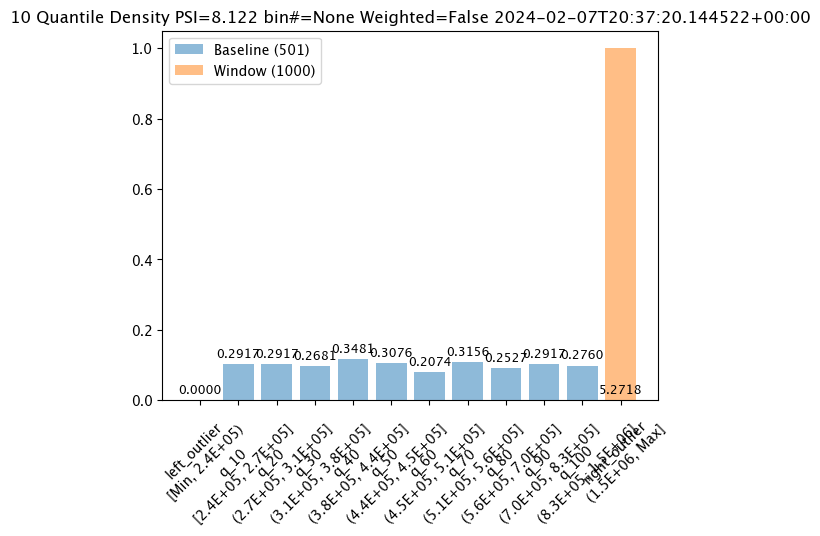

In [65]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# Set the number of bins
# update number of bins here
assay_builder_from_dates.summarizer_builder.add_num_bins(10)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run()[0].chart()
assay_builder_from_dates.build().interactive_run()[1].chart()

#### Binning Mode

Binning Mode defines how the bins are separated.  Binning modes are modified through the `wallaroo.assay_config.UnivariateContinousSummarizerBuilder.add_bin_mode(bin_mode: bin_mode: wallaroo.assay_config.BinMode, edges: Optional[List[float]] = None)`.

Available `bin_mode` values from `wallaroo.assay_config.Binmode` are the following:

* `QUANTILE` (*Default*): Based on percentages. If `num_bins` is 5 then quintiles so bins are created at the 20%, 40%, 60%, 80% and 100% points.
* `EQUAL`: Evenly spaced bins where each bin is set with the formula `min - max / num_bins`
* `PROVIDED`: The user provides the edge points for the bins.

If `PROVIDED` is supplied, then a List of float values must be provided for the `edges` parameter that matches the number of bins.

The following examples are used to show how each of the binning modes effects the bins.

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.00520772807841052
scores = [0.0, 0.0008040331034294781, 0.00010009324303378128, 0.0005128718504664744, 0.0037778397193669257, 1.2890162113860805e-05, 0.0]
index = None


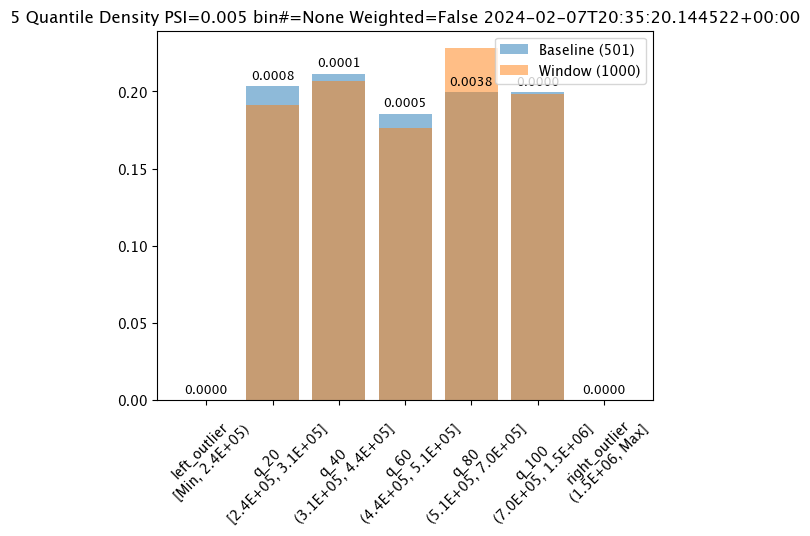

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.8693965086548
scores = [0.0, 0.7361208231835864, 0.7736613502280227, 0.6528484073872128, 0.7174700740703411, 0.7174700740703411, 5.2718257797152965]
index = None


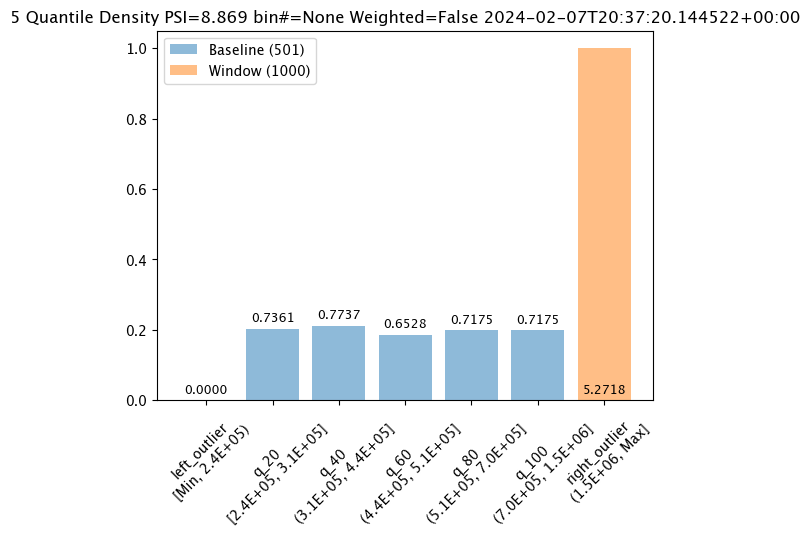

In [72]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# update binning mode here
assay_builder_from_dates.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.QUANTILE)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run()[0].chart()
assay_builder_from_dates.build().interactive_run()[1].chart()

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Equal
aggregation = Density
metric = PSI
weighted = False
score = 0.008987465547991026
scores = [0.0, 0.0011712702034010463, 0.005237576318668655, 0.002545490795026421, 3.3088350602235726e-05, 3.988029266812527e-08, 0.0]
index = None


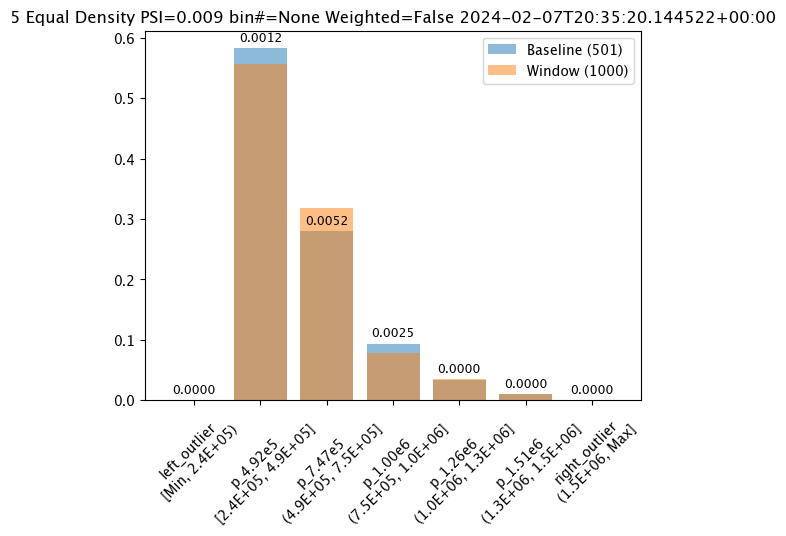

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Equal
aggregation = Density
metric = PSI
weighted = False
score = 9.44483410273556
scores = [0.0, 2.7496044806046247, 1.1041736833164175, 0.26038534988996587, 0.055402858712541976, 0.003441950496713961, 5.2718257797152965]
index = None


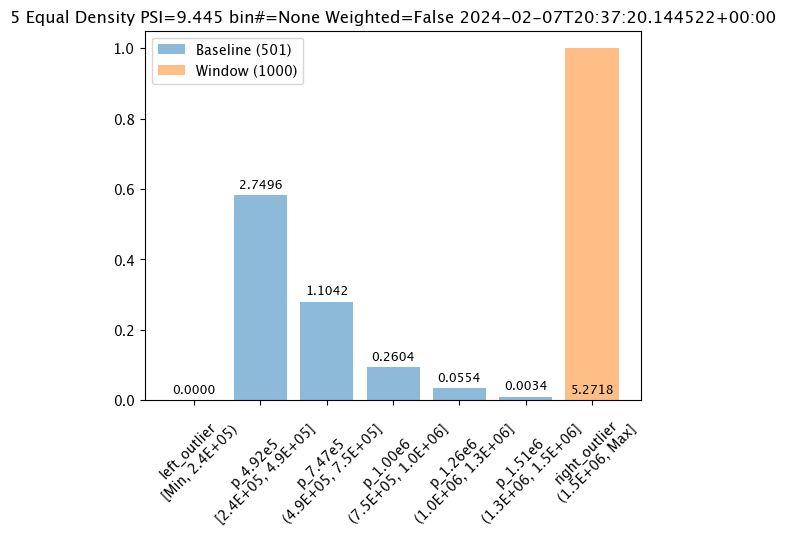

In [73]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# update binning mode here
assay_builder_from_dates.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.EQUAL)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run()[0].chart()
assay_builder_from_dates.build().interactive_run()[1].chart()

The following example manually sets the bin values.

The values in this dataset run from 200000 to 1500000. We can specify the bins with the `BinMode.PROVIDED` and specifying a list of floats with the right hand / upper edge of each bin and optionally the lower edge of the smallest bin. If the lowest edge is not specified the threshold for left outliers is taken from the smallest value in the baseline dataset.

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Provided
aggregation = Density
metric = PSI
weighted = False
score = 0.005723257686942963
scores = [0.0, 4.15606712463904e-05, 0.0001219718347943107, 0.0016642742020801344, 0.001136918951920078, 0.0027585320269020493, 0.0]
index = None


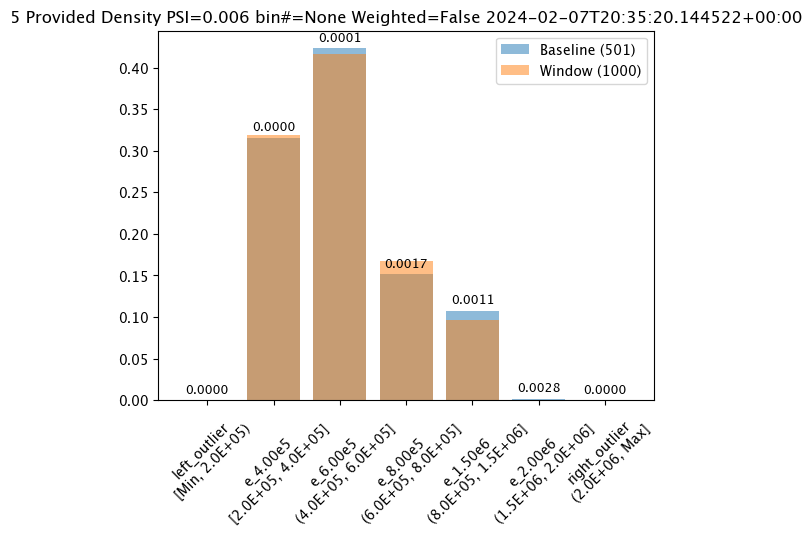

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Provided
aggregation = Density
metric = PSI
weighted = False
score = 9.17024867391807
scores = [0.0, 1.2862652851970542, 1.8558905053305796, 0.5005940445100993, 0.31561967084401865, 3.735674105718412, 1.4762050623179066]
index = None


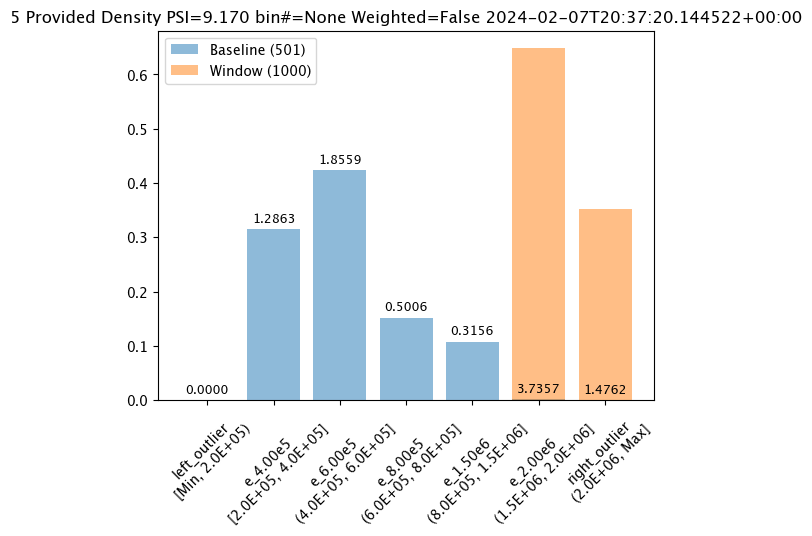

In [81]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

edges = [200000.0, 400000.0, 600000.0, 800000.0, 1500000.0, 2000000.0]

# update binning mode here
assay_builder_from_dates.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.PROVIDED, edges)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run()[0].chart()
assay_builder_from_dates.build().interactive_run()[1].chart()

#### Aggregation Options

Assay aggregation options are modified with the [`wallaroo.assay_config.AssayBuilder.add_aggregation(aggregation: wallaroo.assay_config.Aggregation)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_aggregation) method.  The following options are provided:

* `Aggregation.DENSITY` (*Default*): Count the number/percentage of values that fall in each bin. 
* `Aggregation.CUMULATIVE`: Empirical Cumulative Density Function style, which keeps a cumulative count of the values/percentages that fall in each bin.

The following example demonstrate the different results between the two.

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.00520772807841052
scores = [0.0, 0.0008040331034294781, 0.00010009324303378128, 0.0005128718504664744, 0.0037778397193669257, 1.2890162113860805e-05, 0.0]
index = None


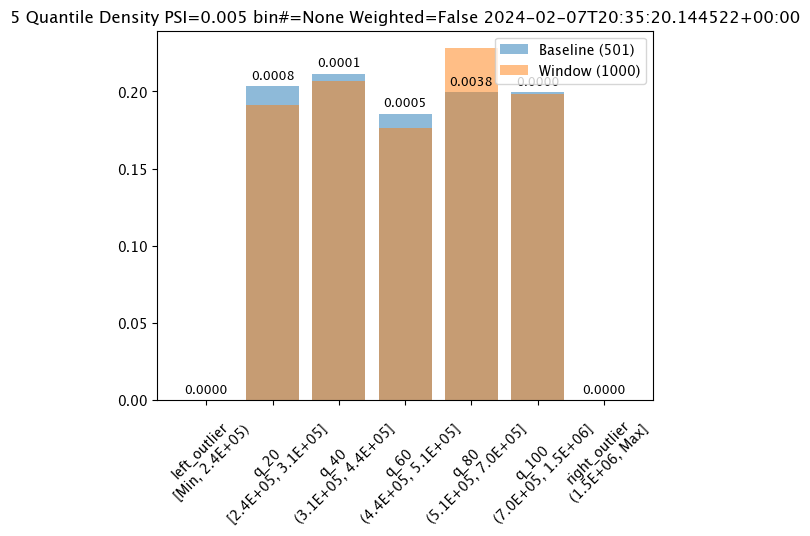

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.8693965086548
scores = [0.0, 0.7361208231835864, 0.7736613502280227, 0.6528484073872128, 0.7174700740703411, 0.7174700740703411, 5.2718257797152965]
index = None


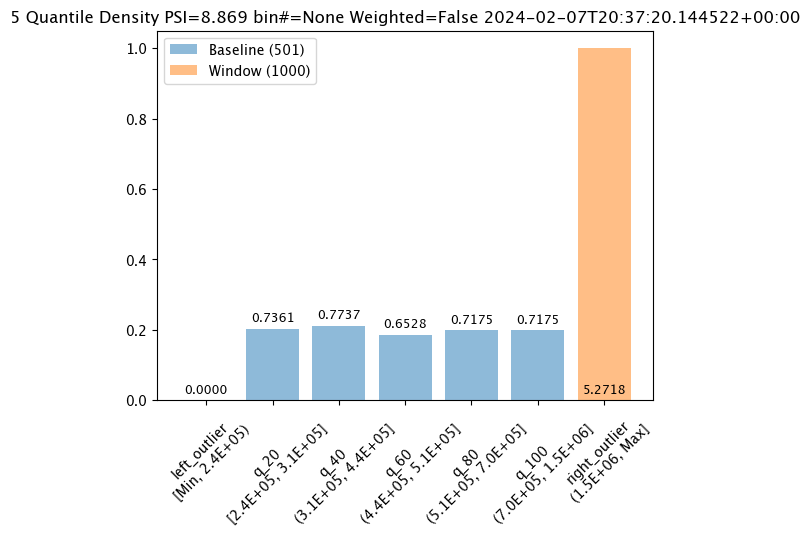

In [83]:
#Aggregation.DENSITY - the default

# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.DENSITY)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run()[0].chart()
assay_builder_from_dates.build().interactive_run()[1].chart()

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Quantile
aggregation = Cumulative
metric = PSI
weighted = False
score = 0.05816167664670657
scores = [0.0, 0.012592814371257475, 0.017169660678642673, 0.02679840319361282, 0.001600798403193604, 0.0, 0.0]
index = None


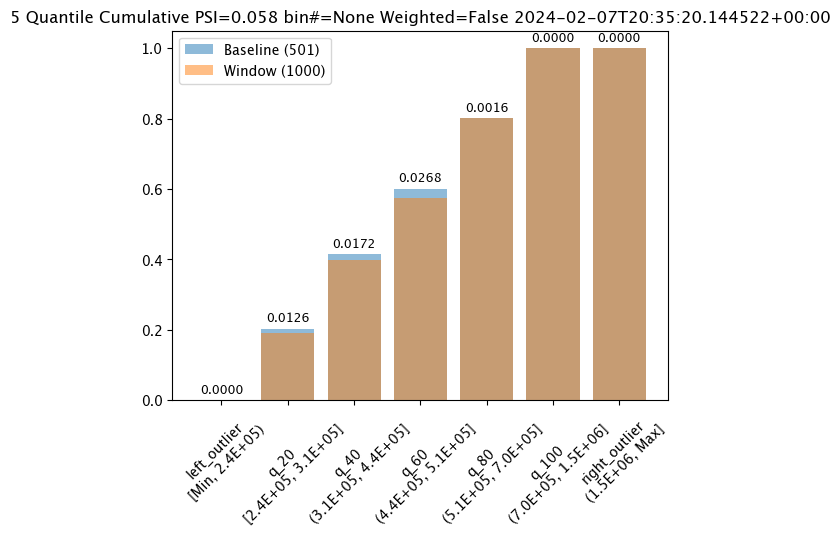

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Quantile
aggregation = Cumulative
metric = PSI
weighted = False
score = 3.019960079840319
scores = [0.0, 0.20359281437125748, 0.4151696606786427, 0.6007984031936128, 0.8003992015968064, 1.0, 0.0]
index = None


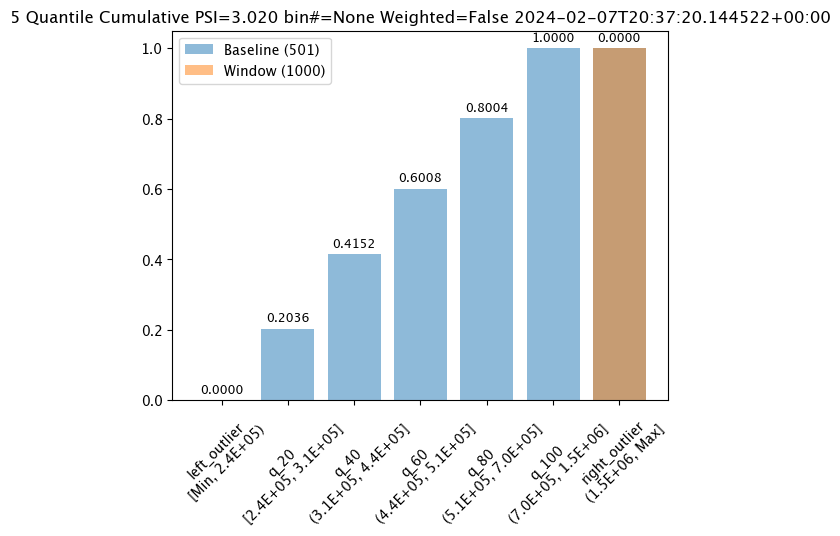

In [84]:
#Aggregation.CUMULATIVE

# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

assay_builder_from_dates.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.CUMULATIVE)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run()[0].chart()
assay_builder_from_dates.build().interactive_run()[1].chart()

#### Compare Basic Stats

The method `wallaroo.assay.AssayAnalysis.compare_basic_stats` returns a DataFrame comparing the baseline with the window.

In [85]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

In [86]:
assay_builder_from_dates.build().interactive_run()[0].compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,501.0,1000.0,499.000000,99.600798
min,236238.671875,236238.671875,0.000000,0.000000
max,1514079.375,1364149.875,-149929.500000,-9.902354
mean,513975.778318,516338.589359,2362.811041,0.459713
median,448627.8125,448627.8125,0.000000,0.000000
std,227020.413509,226046.929731,-973.483778,-0.428809
start,None,2024-02-07T20:35:20.144522+00:00,NaN,NaN
end,None,2024-02-07T20:36:20.144522+00:00,NaN,NaN


In [87]:
assay_builder_from_dates.build().interactive_run()[1].compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,501.0,1000.0,4.990000e+02,99.600798
min,236238.671875,1514079.375,1.277841e+06,540.910890
max,1514079.375,2016006.125,5.019268e+05,33.150623
mean,513975.778318,1883684.608375,1.369709e+06,266.492875
median,448627.8125,1946437.75,1.497810e+06,333.864708
std,227020.413509,162413.538263,-6.460688e+04,-28.458619
start,None,2024-02-07T20:37:20.144522+00:00,NaN,NaN
end,None,2024-02-07T20:38:20.144522+00:00,NaN,NaN


#### Window Interval and Window Width

The window interval sets how often to run the assay analysis.  This is set from the [`wallaroo.assay_config.AssayBuilder.window_builder.add_interval`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#WindowBuilder.add_interval) method to collect data expressed in time units:  "hours=24", "minutes=1", etc.

We can adjust the interval and see how the assays change based on how **frequently** they are run.

The width sets the time period from the [`wallaroo.assay_config.AssayBuilder.window_builder.add_width`](/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#WindowBuilder.add_width) method to collect data expressed in time units:  "hours=24", "minutes=1", etc.

For this example, we'll adjust the width and interval from 1 minute to 5 minutes and see how the number of analyses and their score changes.

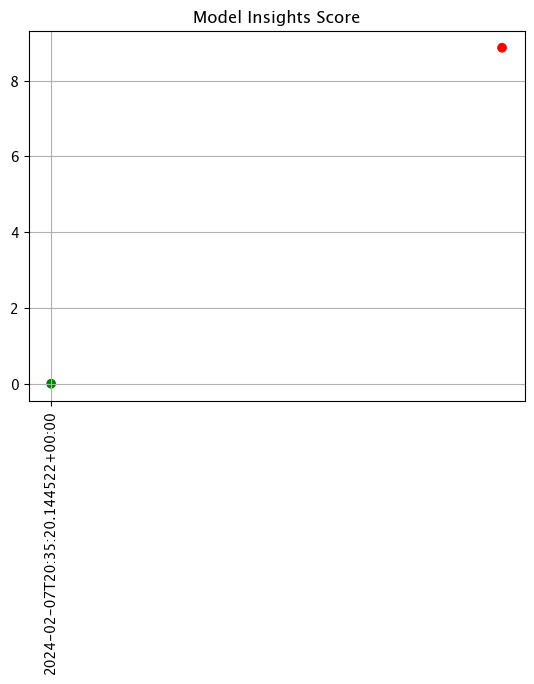

In [96]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run().chart_scores()

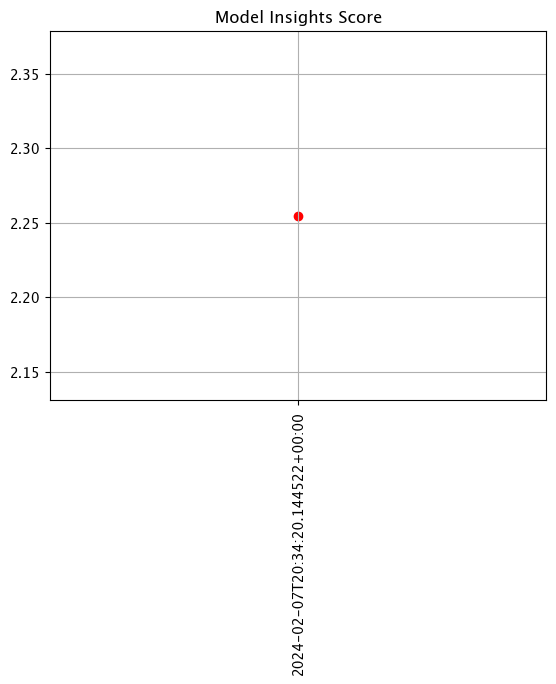

In [98]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=5).add_interval(minutes=5).add_start(assay_window_start)

assay_builder_from_dates.build().interactive_run().chart_scores()

### Create Assay

With the assay created and fully tested, we officially create it by uploading it to the Wallaroo instance.  Once it is uploaded, the assay runs an analysis based on the window width, interval, and the other settings configured.

Assays are uploaded with the `wallaroo.assay_config.upload()` method. This uploads the assay into the Wallaroo database with the configurations applied and returns the assay id. Note that assay names **must be unique across the Wallaroo instance**; attempting to upload an assay with the same name as an existing one will return an error.

`wallaroo.assay_config.upload()` returns the assay id for the assay. 

In [99]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline create sample", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the width, interval, and time period for the assay interactive run
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

assay_builder_from_dates.build()

assay_id = assay_builder_from_dates.upload()

The assay is now visible through the Wallaroo UI by selecting the workspace, then the pipeline, then **Insights**.

![Sample assay in the UI](images/housepricesaga-sample-assay.png)

### Get Assay Results

Once an assay is created the assay runs an analysis based on the window width, interval, and the other settings configured.

Assay results are retrieved with the `wallaroo.client.get_assay_results` method, which takes the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_id** | *Integer* (*Required*) | The numerical id of the assay. |
| **start** | *Datetime.Datetime* (*Required*) | The start date and time of historical data from the pipeline to start analyses from. |
| **end** | *Datetime.Datetime* (*Required*) | The end date and time of historical data from the pipeline to limit analyses to. |

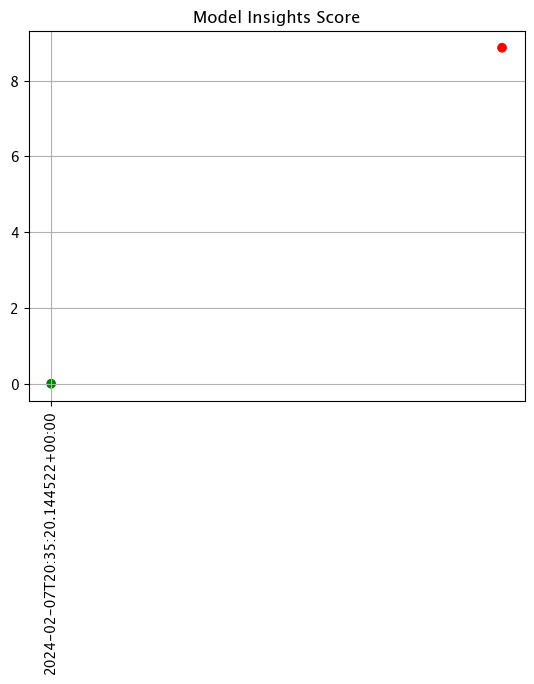

,score,start,alert_threshold,status
0,0.005208,2024-02-07T20:35:20.144522+00:00,0.25,Ok
1,8.869396,2024-02-07T20:37:20.144522+00:00,0.25,Alert


In [101]:
assay_results = wl.get_assay_results(assay_id=assay_id,
                     start=assay_window_start,
                     end=datetime.datetime.now())

assay_results.chart_scores()
assay_results.to_dataframe().loc[:, ['score', 'start', 'alert_threshold', 'status']]

baseline mean = 513975.7783183633
window mean = 516338.589359375
baseline median = 448627.8125
window median = 448627.8125
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.005207728
scores = [0.0, 0.0008040331034294781, 0.00010009324303378128, 0.0005128718504664744, 0.0037778397193669257, 1.2890162113860805e-05, 0.0]
index = None


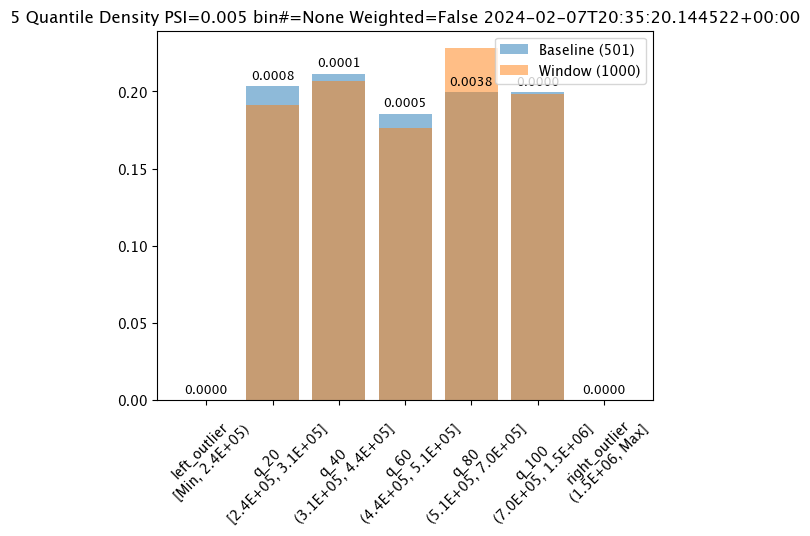

baseline mean = 513975.7783183633
window mean = 1883684.608375
baseline median = 448627.8125
window median = 1946437.75
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 8.869396
scores = [0.0, 0.7361208231835864, 0.7736613502280227, 0.6528484073872128, 0.7174700740703411, 0.7174700740703411, 5.2718257797152965]
index = None


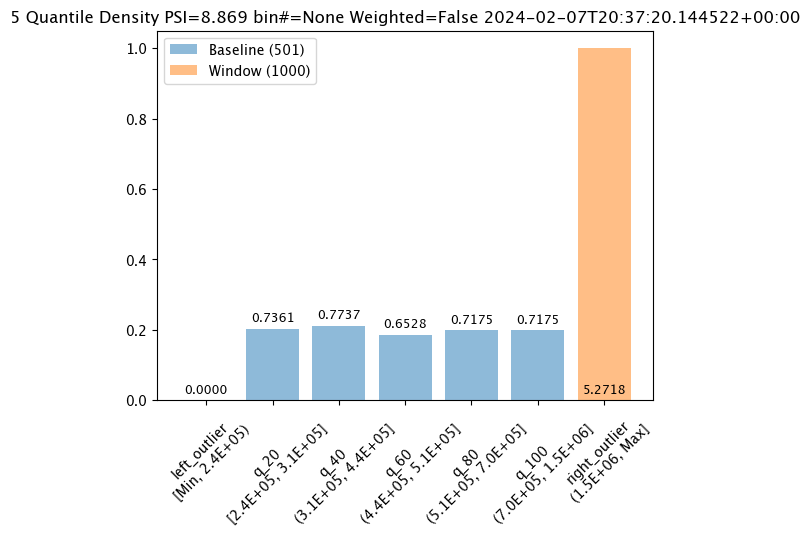

In [102]:
for assay_analysis in assay_results:
    assay_analysis.chart()

#### List and Retrieve Assay

If the assay id is not already know, it is retrieved from the `wallaroo.client.list_assays()` method.  Select the assay to retrieve data for and retrieve its id with `wallaroo.assay.Assay._id` method.

In [104]:
wl.list_assays()

name,active,status,warning_threshold,alert_threshold,pipeline_name
assays from date baseline create sample,True,"{""run_at"": ""2024-02-07T22:48:57.585048639+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from date sample,True,"{""run_at"": ""2024-02-07T22:48:57.560023292+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from date baseline,True,"{""run_at"": ""2024-02-07T22:48:57.573609045+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from numpy,True,created,None,0.25,assay-demonstration-tutorial


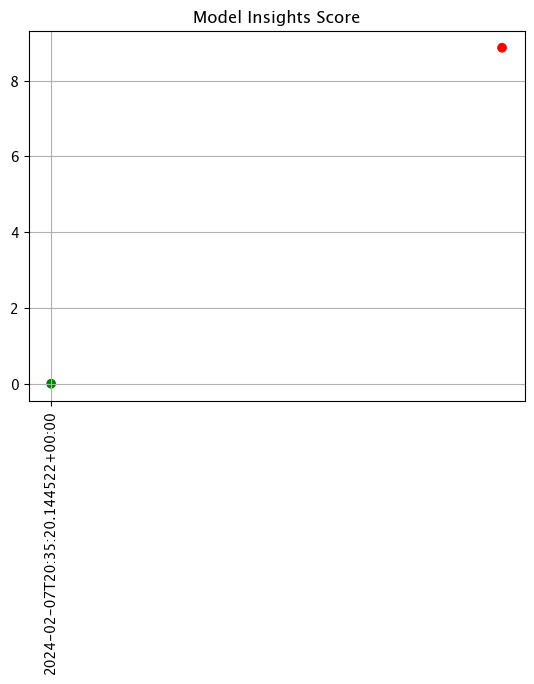

In [110]:
retrieved_assay = wl.list_assays()[0]

assay_results = wl.get_assay_results(assay_id=retrieved_assay._id,
                     start=assay_window_start,
                     end=datetime.datetime.now())

assay_results.chart_scores()


### Pause and Resume Assay

Assays are paused and started with the `wallaroo.assay.Assay.turn_off` and `wallaroo.assay.Assay.turn_on` methods.

For the following, we retrieve an assay from the wallaroo instance and pause it, then list the assays to verify its setting `Active` is `False`.

In [111]:
display(wl.list_assays())
retrieved_assay = wl.list_assays()[0]

retrieved_assay.turn_off()
display(wl.list_assays())

name,active,status,warning_threshold,alert_threshold,pipeline_name
assays from date baseline create sample,True,"{""run_at"": ""2024-02-07T22:54:57.593288283+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from date sample,True,"{""run_at"": ""2024-02-07T22:54:57.569925617+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from date baseline,True,"{""run_at"": ""2024-02-07T22:54:57.582930785+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from numpy,True,created,None,0.25,assay-demonstration-tutorial


name,active,status,warning_threshold,alert_threshold,pipeline_name
assays from date baseline create sample,False,"{""run_at"": ""2024-02-07T22:54:57.593288283+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from date sample,True,"{""run_at"": ""2024-02-07T22:54:57.569925617+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from date baseline,True,"{""run_at"": ""2024-02-07T22:54:57.582930785+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from numpy,True,created,None,0.25,assay-demonstration-tutorial


We resume the assay and verify its setting `Active` is `True`.

In [112]:
retrieved_assay.turn_on()
display(wl.list_assays())

name,active,status,warning_threshold,alert_threshold,pipeline_name
assays from date baseline create sample,True,"{""run_at"": ""2024-02-07T22:57:12.041626554+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from date sample,True,"{""run_at"": ""2024-02-07T22:56:57.573088923+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from date baseline,True,"{""run_at"": ""2024-02-07T22:56:57.586305174+00:00"", ""num_ok"": 0, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.25,assay-demonstration-tutorial
assays from numpy,True,created,None,0.25,assay-demonstration-tutorial


### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [113]:
mainpipeline.undeploy()

name,assay-demonstration-tutorial
created,2024-02-01 19:46:24.140658+00:00
last_updated,2024-02-07 20:33:32.287940+00:00
deployed,False
arch,None
tags,
versions,"f02cf5cd-eece-4ebf-b563-d9d7fad963f6, eedae8d6-ab61-42ab-b9e8-5bf5e4511158, fece4440-2841-45f1-bb5f-95fcdc959327, 9c5a5b72-4976-406b-a4a3-f02e730bb9db, b917929a-01d0-4690-9c08-5edd2094761d"
steps,housepricesagacontrol
published,False
